# 实验四 朴素贝叶斯分类器
- 姓名：马永田
- 学号：2012911
- 专业：计算机科学与技术专业

## 实验要求
### 截止日期：11月18日实验课之前
- 以.ipynb形式的文件提交，输出运行结果，并确保自己的代码能够正确运行
- 发送到邮箱：2120220594@mail.nankai.edu.cn

### 基本要求
1. 采用分层采样的方式将数据集划分为训练集和测试集。
2. 给定编写一个朴素贝叶斯分类器，对测试集进行预测，计算分类准确率。

### 中级要求
1. 使用测试集评估模型，得到混淆矩阵，精度，召回率，F值。

### 高级要求
1. 在中级要求的基础上画出三类数据的ROC曲线，并求出AUC值。

## 实验流程
### 基本要求
#### 数据处理
读取数据并按类别存储并分层采样划分数据集

In [1]:
# -*- coding: UTF-8 -*-
import math
import numpy as np  
import pandas as pd

f = open('./wine.data','r')
types = [[],[],[]]                      #按类分的所有数据
test_data = [[],[],[]]
train_data = [[],[],[]]
data_num = 0                            #数据总数
test_len = []                           #测试集里每一类的个数
means = [[],[],[]]                      #每一类的均值
std = [[],[],[]]                        #每一类的标准差
y_true = []                             #真实值
y_pred = []                             #预测值
y_scores = [[],[],[]]                   #得分
myline = '1'
while myline:
    myline = f.readline().split(',')
    if len(myline) != 14:
        break
    for t in range(len(myline)):
        if t == 0:
            myline[t] = int(myline[t])
        else:
            myline[t] = float(myline[t])
    temp = myline.pop(0)
    types[temp - 1].append(myline)
test_len = [round(len(types[i]) / 4) for i in range(3)]
data_num = sum([len(types[i]) for i in range(3)])

#分层采样划分数据集
for i in range(3):
    index = [i for i in range(len(types[i]))]
    np.random.shuffle(index)
    for j in range(test_len[i]):
        test_data[i].append(types[i][index[j]])
    for j in range(test_len[i],len(types[i])):
        train_data[i].append(types[i][index[j]])
train_num = sum([len(train_data[i]) for i in range(3)])
test_num = sum([len(test_data[i]) for i in range(3)])

#### 分类预测
使用朴素贝叶斯分类器，对测试集进行预测，计算分类准确率。

In [2]:
def type_score(t, mean, std, num_k):
    score = -1 * np.sum(np.log((2*math.pi) ** 0.5 * std) + np.power(t - mean, 2) / (2 * np.power(std, 2))) + math.log(num_k/train_num)
    return score
def bayes_classificate():
    # 首先，分别计算训练集上三个类的均值和标准差
    # mean = ...
    # std = ...
    confusion_matrix = np.zeros((3,3))
    for i in range(3):
        means[i] = np.mean(train_data[i],axis=0)    
        std[i] = np.std(train_data[i],axis=0)   #默认有偏 doff = 1无偏
    wrong_num = 0
    for i in range(3):
        for t in test_data[i]:                  #两层循环：从每一类取每一个测试样本
            my_type = []
            for j in range(3):
                #由于数据集中所有的属性都是连续值，连续值的似然估计可以按照高斯分布来计算：
                score = type_score(t, means[j], std[j], len(train_data[j]))      
                my_type.append(score)        #这里将所有score保存
            #print(my_type)
            pre_type = my_type.index(max(my_type))          #取分值最大的为预测类别
            if pre_type == i:
                confusion_matrix[i][i] += 1
            if pre_type != i:                               #统计错误数
                wrong_num+=1
                confusion_matrix[i][pre_type] += 1
                
            #记录预测结果和得分用于绘制ROC曲线
            y_pred.append(pre_type)
            y_true.append(i)
            for j in range(3):
                y_scores[j].append(np.power(math.e, my_type[j]))

    return (test_num - wrong_num)/test_num, confusion_matrix

### 中级要求
使用测试集评估模型，得到混淆矩阵，精度，召回率，F值。

In [3]:
# 模型评估 计算精确率和召回值
def model_evaluation(confusion_matrix):
    print("Confusion Matrix:")
    print(confusion_matrix)
    precision = np.zeros(3)
    recall = np.zeros(3)
    for i in range(3):
        rowsum, colsum = sum(confusion_matrix[i]), sum(confusion_matrix[r][i] for r in range(3))
        precision[i] = (confusion_matrix[i][i]/float(colsum))
        recall[i] = (confusion_matrix[i][i]/float(rowsum))
        print("class",i+1)
        print("precision:\t",precision[i]*100,"%")
        print("recall:\t\t",recall[i]*100,"%")
    pr = np.average(precision)
    re = np.average(recall)
    print("F= %s" %(2*pr*re/(pr+re)))

In [4]:
acc_rate,c_matrix = bayes_classificate()
print("Accuracy Rate:\t",acc_rate)
model_evaluation(c_matrix)

Accuracy Rate:	 0.9777777777777777
Confusion Matrix:
[[15.  0.  0.]
 [ 0. 17.  1.]
 [ 0.  0. 12.]]
class 1
precision:	 100.0 %
recall:		 100.0 %
class 2
precision:	 100.0 %
recall:		 94.44444444444444 %
class 3
precision:	 92.3076923076923 %
recall:		 100.0 %
F= 0.9779072590434573


### 高级要求
在中级要求的基础上画出三类数据的ROC曲线，并求出AUC值。

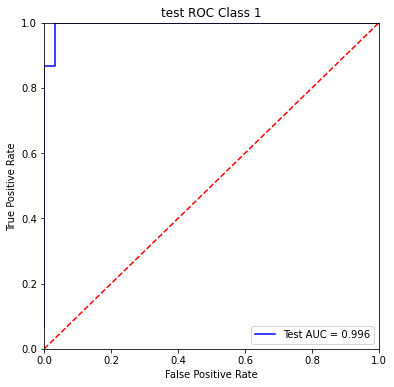

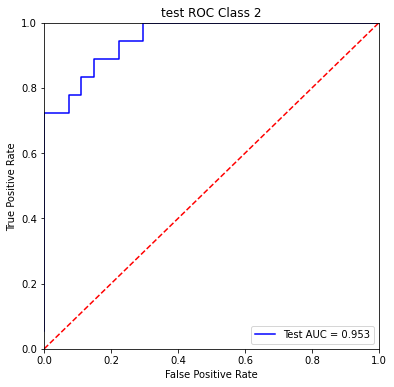

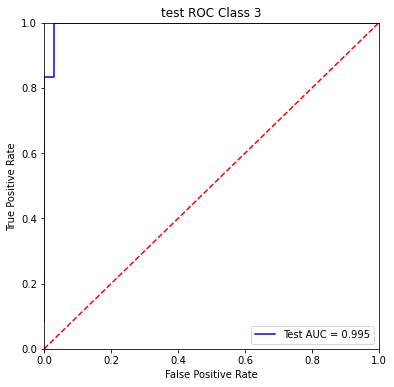

In [5]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
for Class_index in range(3):
    # 按照测试样本的score进行降序排序
    sorted_id = sorted(range(len(y_scores[Class_index])), key=lambda k: y_scores[Class_index][k], reverse = True)
    
    x = 0   # 负样本累计 
    y = 0   # 正样本累计
    fpr = []    # 横轴坐标
    tpr = []    # 纵轴坐标
    roc_auc = 0     #auc值

    for i in range(len(sorted_id)):
        if y_true[sorted_id[i]] == Class_index:
            y += 1  # print("↑") 沿纵轴方向绘制一个刻度间隔的曲线
            fpr.append(x)
            tpr.append(y)
        else :
            x += 1  # print("→") 沿横轴方向绘制一个刻度间隔的曲线
            fpr.append(x)
            tpr.append(y)
    # 计算fpr和tpr
    fpr = np.divide(fpr ,x)
    tpr = np.divide(tpr ,y)

    # 计算曲线面积 即AUC值
    for i in range(len(sorted_id) - 1):
        if fpr[i + 1]!=fpr[i]:
            roc_auc += tpr[i]
    roc_auc  = roc_auc / x

    # 绘制ROC曲线
    plt.figure(figsize=(6,6))
    plt.title('test ROC Class ' + str(Class_index + 1))
    plt.plot(fpr, tpr, 'b', label = 'Test AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    # x_major_locator = MultipleLocator(1/x)
    # y_major_locator = MultipleLocator(1/y)
    # ax = plt.gca()
    # ax.xaxis.set_major_locator(x_major_locator)
    # ax.yaxis.set_major_locator(y_major_locator)    
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

调用sklearn库的metrics误差函数绘制ROC曲线进行对比

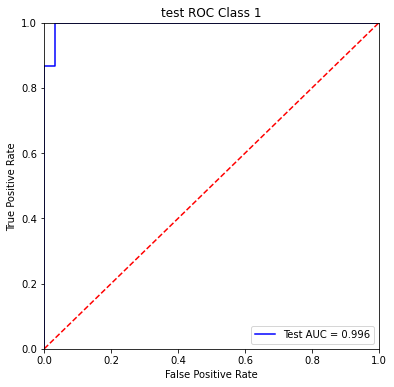

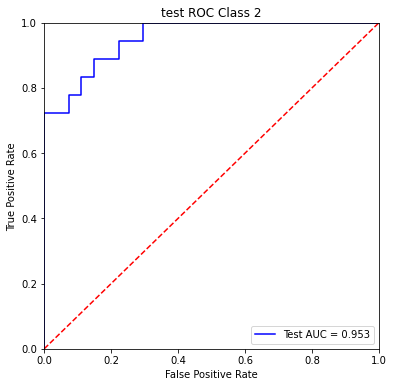

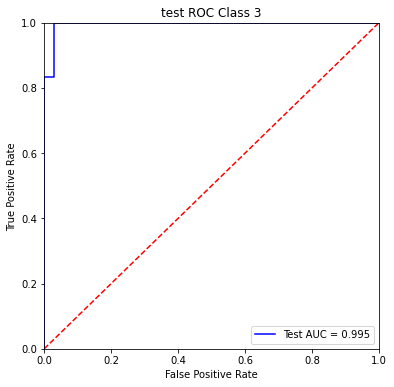

In [6]:
from sklearn import metrics
for Class_index in range(3):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_scores[Class_index], pos_label=Class_index)
    roc_auc = metrics.auc(fpr, tpr) 
    plt.figure(figsize=(6,6))
    plt.title('test ROC Class ' + str(Class_index + 1))
    plt.plot(fpr, tpr, 'b', label = 'Test AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
